In [14]:
import os

classes = ["kangaroo","raccoon"]
annot_lists=[]
for classename in classes:
    my_source="dataset/%s/Annotations"%(classename)
    for dirpath, dirname, files in os.walk(my_source):
        for file in files:
            annot_lists.append("./"+dirpath+"/"+file)
            
if not os.path.exists("K&C_train1.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    # 資料類別
    classes = ["kangaroo","raccoon"]

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(classname, image_id, list_file):
        in_file = open('dataset/%s/Annotations/%s.xml'%(classname, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    annotation_path='K&C_train.txt'
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    for i in range(len(annot_lists)):
        list_file.write(annot_lists[i].replace("Annotations","images").replace("xml","jpg") )
        image_id=annot_lists[i].split('/')[-1].split('.xml')[0]
        classname=annot_lists[i].split('/')[2]
        convert_annotation(classname,image_id, list_file)
        list_file.write('\n')
    list_file.close()

    
   

save annotation at K&C_train.txt


In [2]:
import os
if not os.path.exists("model_data/yolo_weights.h5"):
    # 下載 yolov3 的網路權重(.weights)，並且把權重轉換為 keras 能夠讀取的格式(.h5)
    print("Converting pretrained YOLOv3 weights for training")
    #把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重,注意argument 要使用 -w 
    os.system("python convert.py -w yolov3.cfg model_data/yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [3]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [16]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [5]:
annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/K&C_classes.txt' # 加入類別 kangaroo & raccoon
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\wjr63\Anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\wjr63\Anaconda3\lib\site-packages\keras\engine\topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_75

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 328 samples, val on 36 samples, with batch size 16.
Epoch 1/50
20/20 [==============================] - 27s 1s/step - loss: 4552.1549 - val_loss: 1278.4669
Epoch 2/50
20/20 [==============================] - 22s 1s/step - loss: 722.8932 - val_loss: 377.5003
Epoch 3/50
20/20 [==============================] - 22s 1s/step - loss: 302.9742 - val_loss: 201.2571
Epoch 4/50
20/20 [==============================] - 15s 740ms/step - loss: 200.0702 - val_loss: 144.8575
Epoch 5/50
20/20 [==============================] - 22s 1s/step - loss: 161.0711 - val_loss: 116.5430
Epoch 6/50
20/20 [==============================] - 22s 1s/step - loss: 129.1055 - val_loss: 113.1101
Epoch 7/50
20/20 [==============================] - 22s 1s/step - loss: 106.9332 - val_loss: 90.8225
Epoch 8/50
20/20 [==============================] - 22s 1s/step - loss: 97.1912 - val_loss: 75.9261
Epoch 9/50
20/20 [=============

In [9]:
input_shape = (416,416) # multiple of 32, hw
weights_path=log_dir + 'trained_weights_stage_1.h5'
model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    weights_path=log_dir + 'trained_tiny_weights_stage_1.h5'
    model = create_tiny_model(input_shape, anchors, num_classes,weights_path=weights_path)
else:
    weights_path=log_dir + 'trained_weights_stage_1.h5'
    model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 2 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.
Load weights logs/000/trained_weights_stage_1.h5.
Freeze the first 249 layers of total 252 layers.
Create YOLOv3 model with 9 anchors and 2 classes.
Load weights logs/000/trained_weights_stage_1.h5.
Freeze the first 249 layers of total 252 layers.
Unfreeze all of the layers.
Train on 328 samples, val on 36 samples, with batch size 2.
Epoch 51/100
164/164 [==============================] - 79s 482ms/step - loss: 18.7976 - val_loss: 17.9433
Epoch 52/100
164/164 [==============================] - 68s 417ms/step - loss: 17.3789 - val_loss: 18.5257
Epoch 53/100
164/164 [==============================] - 67s 407ms/step - loss: 16.7853 - val_loss: 18.1110
Epoch 54/100
164/164 [==============================] - 67s 407ms/step - loss: 16.6216 - val_loss: 15.3613
Epoch 55/100
164/164 [==============================] - 67s 406ms/step - loss: 15.8383 - val_loss: 17.6164
Epoch 56/100
164/164 [==============================] - 67s 408ms/step - loss: 

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 4 boxes for img
raccoon 0.87 (1098, 77) (1546, 528)
raccoon 0.98 (657, 71) (1178, 620)
kangaroo 0.61 (141, 97) (557, 539)
kangaroo 0.66 (0, 35) (292, 611)
3.26249550000648


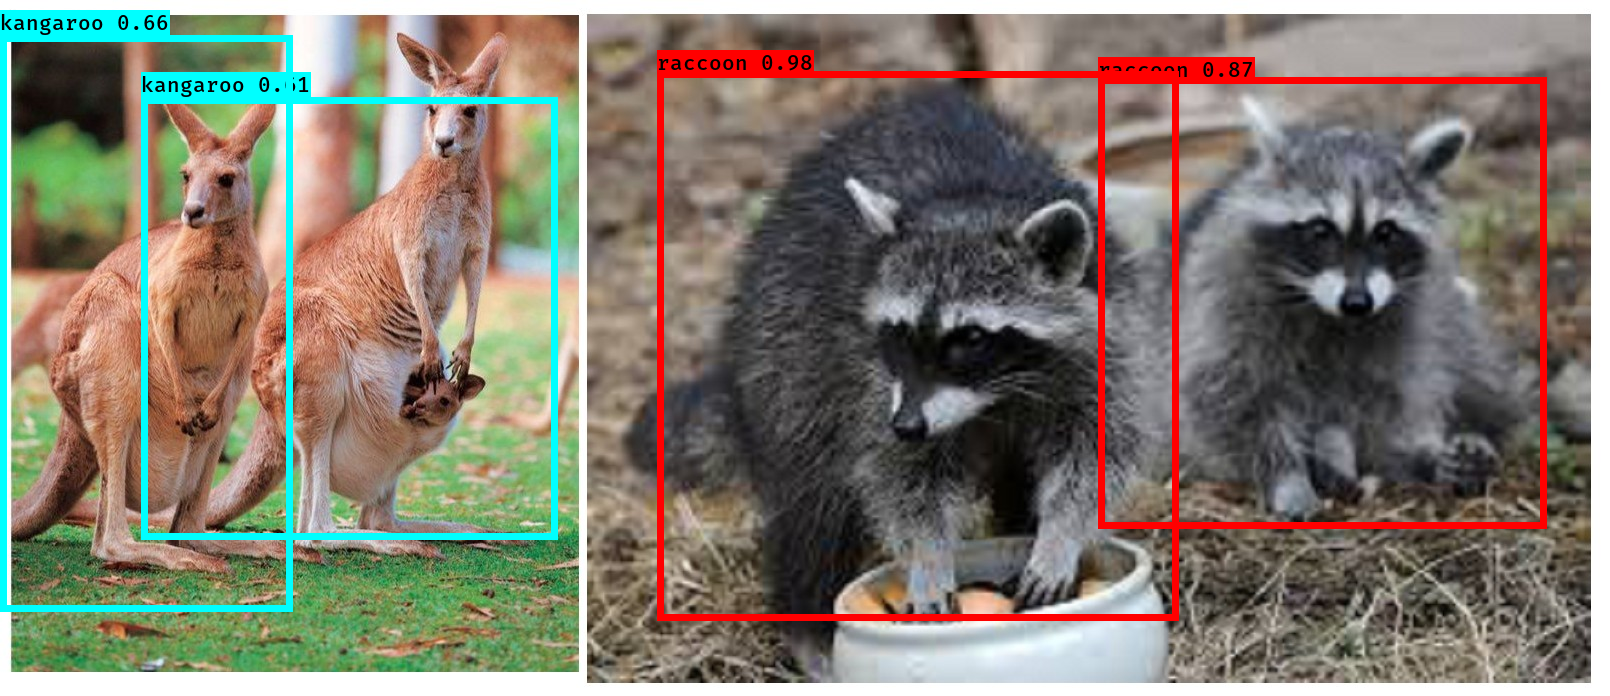

In [19]:
from yolo import YOLO

annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/K&C_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
from PIL import Image
image = Image.open('kangaroom-raccoon-img2.jpg')  # 選擇測試用照片
r_image = yolo_model.detect_image(image)
r_image

In [21]:
def video_detect(video_path, output_path):
    import cv2
    import numpy as np
    from PIL import Image
    import timeit

    starttime = timeit.default_timer()
    cap = cv2.VideoCapture(video_path)

    # 使用 XVID 編碼
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    # 建立 VideoWriter 物件，輸出影片至 output.avi , FPS 值為 30.0，解析度為 1280*720
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (1280, 720))

    k = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            # 寫入影格
            image = Image.fromarray(frame)
            image = np.array(yolo_model.detect_image(image))
            out.write(image)
            k += 1
        else:
            break
        
    # 釋放所有資源
    cap.release()
    out.release()
    print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

In [22]:
# Kangaroo 影片
video_path = 'video/Kangaroo.mp4'
output_path = 'video/Kangaroo-yolo.mp4'
video_detect(video_path=video_path, output_path=output_path)


# Raccoon 影片
video_path = 'video/Raccoon.mp4'
output_path = 'video/Raccoon-yolo.mp4'
video_detect(video_path=video_path, output_path=output_path)    



(416, 416, 3)
Found 0 boxes for img
3.6651387000019895
(416, 416, 3)
Found 0 boxes for img
0.0724569000012707
(416, 416, 3)
Found 0 boxes for img
0.07003800000529736
(416, 416, 3)
Found 0 boxes for img
0.07323510000423994
(416, 416, 3)
Found 0 boxes for img
0.06960970000363886
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (245, 0) (1252, 720)
0.07253309999941848
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (238, 0) (1257, 720)
0.07088449998991564
(416, 416, 3)
Found 0 boxes for img
0.06808729999465868
(416, 416, 3)
Found 0 boxes for img
0.06989189999876544
(416, 416, 3)
Found 0 boxes for img
0.06828649999806657
(416, 416, 3)
Found 0 boxes for img
0.0691301999904681
(416, 416, 3)
Found 0 boxes for img
0.06783519999589771
(416, 416, 3)
Found 0 boxes for img
0.06699209999351297
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (130, 0) (724, 577)
0.0713982000015676
(416, 416, 3)
Found 0 boxes for img
0.06804329999431502
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (120, 0) (73

(416, 416, 3)
Found 0 boxes for img
0.06925960000080522
(416, 416, 3)
Found 0 boxes for img
0.06781110000156332
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (503, 11) (1132, 685)
0.07233750000887085
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (503, 11) (1132, 685)
0.06949590001022443
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (498, 15) (1137, 684)
0.06938840000657365
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (519, 5) (1125, 707)
0.0708740999980364
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (522, 49) (1119, 704)
0.06932840000081342
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (506, 25) (1135, 712)
0.07121860000188462
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (506, 25) (1133, 712)
0.06973830000788439
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (509, 33) (1124, 707)
0.06964160001371056
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (502, 6) (1139, 703)
0.07248360000085086
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (505, 10) (11

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 0) (1128, 709)
0.07292010000674054
(416, 416, 3)
Found 2 boxes for img
raccoon 0.92 (0, 0) (1141, 714)
kangaroo 0.36 (127, 0) (1111, 646)
0.07646700000623241
(416, 416, 3)
Found 2 boxes for img
raccoon 0.92 (0, 0) (1130, 716)
kangaroo 0.31 (130, 0) (1106, 649)
0.07234790000075009
(416, 416, 3)
Found 2 boxes for img
raccoon 0.92 (0, 0) (1130, 717)
kangaroo 0.31 (130, 0) (1106, 650)
0.07241280000016559
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (1130, 698)
0.07028330001048744
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (1086, 694)
0.06928640000114683
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (5, 0) (1049, 702)
0.06926259999454487
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (23, 0) (1027, 691)
0.07074949999514502
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (26, 0) (1025, 693)
0.06944420000945684
(416, 416, 3)
Found 2 boxes for img
raccoon 0.77 (31, 0) (1019, 699)
kangaroo 0.41 (65, 0) (1002, 666

(416, 416, 3)
Found 0 boxes for img
0.07093370000075083
(416, 416, 3)
Found 0 boxes for img
0.07158230000641197
(416, 416, 3)
Found 0 boxes for img
0.07101450000482146
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (87, 29) (325, 446)
0.07442380000429694
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (88, 32) (324, 444)
0.07316510000964627
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (89, 31) (324, 444)
0.07401650000247173
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (90, 29) (322, 447)
0.07465490000322461
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (90, 36) (326, 439)
0.07406559999799356
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (90, 33) (327, 441)
0.07367470000463072
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (92, 36) (327, 439)
0.07396799999696668
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (93, 37) (326, 439)
0.07145920000039041
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (94, 39) (328, 435)
0.07278719999885652
(416, 416, 3)
Found 1 

(416, 416, 3)
Found 0 boxes for img
0.06961510000110138
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (832, 449) (1063, 525)
0.07023599999956787
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (503, 386) (706, 476)
kangaroo 0.48 (399, 102) (506, 198)
kangaroo 0.76 (851, 452) (1056, 533)
0.0733061000064481
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (731, 108) (808, 186)
kangaroo 0.44 (432, 95) (517, 202)
kangaroo 0.51 (867, 457) (1053, 519)
kangaroo 0.57 (527, 377) (706, 480)
0.07443500000226777
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (894, 471) (1115, 529)
0.07119849999435246
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (891, 471) (1116, 530)
0.07094739998865407
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (900, 466) (1109, 537)
0.07218940000166185
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (559, 363) (783, 477)
kangaroo 0.46 (910, 459) (1120, 541)
0.07598880000296049
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (944, 464) (1157, 539)
kangar

Found 1 boxes for img
kangaroo 0.39 (0, 43) (184, 441)
0.07095120000303723
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (0, 43) (184, 441)
0.07185370000661351
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (0, 58) (194, 429)
0.07052709998970386
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (19, 27) (188, 456)
0.07255259998783004
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (15, 36) (193, 449)
0.06942340001114644
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (14, 42) (197, 445)
0.07215749999159016
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (14, 42) (196, 446)
0.0709536000067601
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (754, 235) (941, 465)
kangaroo 0.67 (10, 43) (201, 446)
0.0708502000052249
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (757, 238) (941, 463)
kangaroo 0.73 (11, 50) (200, 439)
0.07260459999088198
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (760, 242) (943, 459)
kangaroo 0.74 (12, 57) (201, 432)
0.07090659999812488
(416, 416, 

Found 2 boxes for img
kangaroo 0.75 (659, 326) (1040, 576)
kangaroo 0.92 (223, 330) (821, 600)
0.07543240000086371
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (653, 326) (1040, 577)
kangaroo 0.91 (224, 331) (819, 599)
0.07659519999288023
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (634, 359) (1045, 586)
kangaroo 0.92 (205, 330) (741, 613)
0.0752924999978859
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (643, 352) (1026, 635)
kangaroo 0.92 (139, 337) (788, 622)
0.0743823000084376
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.76 (101, 354) (809, 623)
kangaroo 0.80 (631, 357) (1033, 606)
0.07200220000231639
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (264, 348) (856, 631)
kangaroo 0.78 (636, 333) (1035, 565)
0.07644520000030752
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (264, 348) (855, 631)
kangaroo 0.78 (636, 334) (1034, 565)
0.07555069999943953
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.63 (272, 347) (829, 632)
kangaroo 0.84 (650, 321) (1040, 524)
0.08

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.82 (0, 279) (484, 511)
kangaroo 0.96 (465, 360) (831, 593)
0.07767530001001433
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (461, 322) (837, 573)
0.07468960000551306
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (0, 332) (586, 544)
kangaroo 0.57 (454, 318) (866, 534)
0.0765462999988813
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (0, 332) (587, 545)
kangaroo 0.56 (453, 317) (867, 535)
0.07575249999354128
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (0, 359) (590, 540)
kangaroo 0.92 (448, 324) (872, 514)
0.07440850000421051
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (0, 352) (573, 551)
kangaroo 0.89 (440, 311) (875, 524)
0.07357049999700394
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (656, 56) (1082, 597)
0.07399779999104794
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (656, 72) (1085, 600)
0.0769572999997763
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (656, 72) (1085, 601)
0.07467270000779536
(416

(416, 416, 3)
Found 0 boxes for img
0.06901370000559837
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (37, 0) (1277, 706)
0.07419139999547042
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (0, 0) (1280, 720)
0.07075620000250638
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (0, 0) (1280, 720)
0.07332260000112001
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (0, 0) (1280, 720)
0.07212209999852348
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (0, 0) (1280, 720)
0.07056269999884535
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (0, 0) (1280, 720)
0.0711855999979889
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (0, 0) (1280, 720)
0.07021190000523347
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 0) (1280, 720)
0.07032719999551773
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (7, 0) (1280, 720)
0.06987580000713933
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (15, 0) (1280, 720)
0.07065939999301918
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (24, 0) (1280,

Found 1 boxes for img
raccoon 0.43 (0, 0) (1280, 635)
0.07071780000114813
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (0, 0) (1280, 636)
0.06963309999264311
(416, 416, 3)
Found 0 boxes for img
0.06863979999616276
(416, 416, 3)
Found 0 boxes for img
0.06984129999182187
(416, 416, 3)
Found 0 boxes for img
0.06914370000595227
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (0, 0) (1280, 585)
0.07122359999630135
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 0) (1280, 581)
0.07123990000400227
(416, 416, 3)
Found 0 boxes for img
0.06912859999283683
(416, 416, 3)
Found 0 boxes for img
0.06831859999510925
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (0, 29) (1149, 651)
0.07062040000164416
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 24) (1152, 657)
0.07154069999523927
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 24) (1154, 656)
0.07000910000351723
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (21, 0) (1115, 712)
0.06999470001028385
(416, 416, 3)
Found 1 

Found 1 boxes for img
raccoon 0.54 (0, 89) (1280, 638)
0.07070209999801591
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (0, 94) (1280, 622)
0.07017559999076184
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (0, 83) (1280, 614)
0.07065599999623373
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (0, 82) (1280, 614)
0.07088640000438318
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (0, 77) (1280, 605)
0.07004869999946095
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (0, 85) (1280, 587)
0.07174499999382533
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (0, 97) (1280, 576)
0.07135759999800939
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (0, 106) (1280, 547)
0.07105440000304952
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (0, 108) (1280, 546)
0.0731861999956891
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (0, 89) (1280, 568)
0.07170669999322854
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (32, 19) (1249, 556)
0.06981079999241047
(416, 416, 3)
Found 2 boxes for i

(416, 416, 3)
Found 2 boxes for img
raccoon 0.71 (0, 0) (1231, 696)
kangaroo 0.67 (90, 0) (1155, 562)
0.07200830000510905
(416, 416, 3)
Found 2 boxes for img
raccoon 0.75 (0, 0) (1243, 720)
kangaroo 0.51 (57, 0) (1182, 554)
0.07333649999054614
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69 (0, 0) (1250, 720)
kangaroo 0.62 (54, 0) (1183, 552)
0.07275530000333674
(416, 416, 3)
Found 2 boxes for img
raccoon 0.64 (0, 0) (1221, 708)
kangaroo 0.70 (80, 18) (1163, 555)
0.07299590000184253
(416, 416, 3)
Found 2 boxes for img
raccoon 0.59 (0, 0) (1165, 558)
kangaroo 0.46 (141, 0) (1119, 562)
0.07201279999571852
(416, 416, 3)
Found 2 boxes for img
raccoon 0.76 (0, 16) (1238, 651)
kangaroo 0.40 (49, 28) (1204, 647)
0.0719093000079738
(416, 416, 3)
Found 2 boxes for img
raccoon 0.71 (0, 23) (1202, 648)
kangaroo 0.55 (83, 54) (1165, 631)
0.07163130000117235
(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (0, 23) (1202, 649)
kangaroo 0.54 (82, 54) (1166, 631)
0.07199299999047071
(416, 416, 3)
Fou

kangaroo 0.32 (396, 394) (507, 542)
kangaroo 0.51 (948, 445) (1040, 604)
0.07224049999786075
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (394, 396) (506, 534)
kangaroo 0.75 (951, 424) (1046, 622)
0.0733116999908816
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (961, 433) (1063, 598)
0.07069379999302328
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (979, 419) (1095, 570)
kangaroo 0.73 (742, 408) (856, 540)
0.07284190000791568
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (979, 419) (1095, 570)
kangaroo 0.73 (742, 408) (856, 540)
0.0720450999942841
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (403, 366) (510, 531)
kangaroo 0.76 (747, 409) (858, 563)
0.07291000000259373
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (752, 412) (862, 573)
0.07152929999574553
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (769, 458) (862, 572)
0.07043620001059026
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (1024, 471) (1149, 616)
kangaroo 0.33 (773, 455) (856, 582)
kangaro

(416, 416, 3)
Found 0 boxes for img
0.06979589999536984
(416, 416, 3)
Found 0 boxes for img
0.06904400000348687
(416, 416, 3)
Found 0 boxes for img
0.06838199999765493
(416, 416, 3)
Found 0 boxes for img
0.07039770000847057
(416, 416, 3)
Found 0 boxes for img
0.0693533000012394
(416, 416, 3)
Found 0 boxes for img
0.0687340000004042
(416, 416, 3)
Found 0 boxes for img
0.0683463000023039
(416, 416, 3)
Found 0 boxes for img
0.06846110000333283
(416, 416, 3)
Found 0 boxes for img
0.06929310000850819
(416, 416, 3)
Found 0 boxes for img
0.06954060000134632
(416, 416, 3)
Found 0 boxes for img
0.06965629999467637
(416, 416, 3)
Found 0 boxes for img
0.06843379999918398
(416, 416, 3)
Found 0 boxes for img
0.06830870000703726
(416, 416, 3)
Found 0 boxes for img
0.06910920000518672
(416, 416, 3)
Found 0 boxes for img
0.07002210000064224
(416, 416, 3)
Found 0 boxes for img
0.0709422999934759
(416, 416, 3)
Found 0 boxes for img
0.06990719999885187
(416, 416, 3)
Found 0 boxes for img
0.06938140001147

(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (182, 0) (1280, 720)
0.06968280000728555
(416, 416, 3)
Found 0 boxes for img
0.06950529999448918
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (34, 0) (1280, 720)
0.07164589999592863
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (0, 0) (1280, 720)
0.07061959999555256
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (16, 0) (1280, 720)
0.06932710000546649
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (29, 0) (1280, 720)
0.07148339999548625
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (1280, 720)
0.0695547999930568
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (0, 0) (1280, 720)
0.07097450000583194
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (56, 0) (1266, 720)
0.07121549999283161
(416, 416, 3)
Found 0 boxes for img
0.06842999999935273
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (51, 0) (1259, 720)
0.07007319999684114
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 0) (1280, 720)
0.069781400001375
(416

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (333, 18) (924, 681)
0.06998319999547675
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (346, 32) (926, 668)
0.06994480000867043
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (345, 31) (926, 668)
0.06975989999773446
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (350, 35) (921, 664)
0.069572699998389
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (359, 33) (914, 665)
0.06962370000837836
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (371, 31) (907, 666)
0.07022080000024289
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (382, 23) (916, 668)
0.07007579998753499
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (382, 23) (916, 668)
0.06948560000455473
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (391, 21) (911, 668)
0.07038819999434054
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.45 (486, 15) (951, 663)
0.07034109999949578
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (484, 13) (949, 666)
0.07012899999972433
(

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (426, 305) (539, 631)
kangaroo 0.32 (528, 183) (799, 577)
kangaroo 0.37 (943, 423) (1258, 541)
0.07689369999570772
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (425, 305) (539, 631)
kangaroo 0.32 (528, 183) (799, 577)
kangaroo 0.37 (943, 423) (1258, 541)
0.07550690000061877
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (945, 421) (1257, 543)
0.07173340000736061
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (945, 421) (1255, 546)
kangaroo 0.61 (416, 310) (597, 594)
0.07284019999497104
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (426, 306) (585, 598)
0.0701753000030294
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (936, 425) (1262, 546)
kangaroo 0.50 (420, 324) (590, 577)
0.07179099999484606
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (936, 425) (1262, 546)
kangaroo 0.53 (416, 327) (593, 572)
0.07136099999479484
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (944, 424) (1253, 543)
kangaroo 0.40 (417, 326) (

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (801, 243) (930, 550)
0.08166019999771379
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (132, 324) (309, 573)
kangaroo 0.59 (805, 241) (927, 551)
0.07799440000962932
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (804, 240) (928, 551)
0.07346450000477489
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (805, 242) (927, 551)
0.0749562999990303
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (805, 242) (925, 557)
0.07881099999940488
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (805, 242) (923, 561)
0.07684249999874737
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (800, 236) (923, 566)
0.07577349999337457
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (800, 236) (923, 566)
0.07721299999684561
(416, 416, 3)
Found 0 boxes for img
0.07247730001108721
(416, 416, 3)
Found 0 boxes for img
0.07257560000289232
(416, 416, 3)
Found 0 boxes for img
0.0710730999999214
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (372, 239) (

(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (711, 0) (1191, 720)
0.07228730000497308
(416, 416, 3)
Found 0 boxes for img
0.06778289999056142
(416, 416, 3)
Found 0 boxes for img
0.06967640000220854
(416, 416, 3)
Found 0 boxes for img
0.06788000000233296
(416, 416, 3)
Found 0 boxes for img
0.06843030000163708
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (230, 0) (1270, 700)
0.07021660001191776
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (284, 0) (1280, 720)
0.07053740000992548
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (354, 0) (1280, 720)
0.07000669999979436
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (349, 0) (1280, 720)
0.0711211000016192
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (378, 0) (1280, 720)
0.06972410000162199
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (399, 0) (1280, 716)
0.07040389999747276
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (440, 0) (1254, 708)
kangaroo 0.42 (440, 0) (1254, 708)
0.07138129998929799
(416, 416, 3)
Found 1 

(416, 416, 3)
Found 0 boxes for img
0.06794310000259429
(416, 416, 3)
Found 0 boxes for img
0.0682063999993261
(416, 416, 3)
Found 0 boxes for img
0.06783109999378212
(416, 416, 3)
Found 0 boxes for img
0.06852630000503268
(416, 416, 3)
Found 0 boxes for img
0.06852489999437239
(416, 416, 3)
Found 0 boxes for img
0.0680970000103116
(416, 416, 3)
Found 0 boxes for img
0.06800179999845568
(416, 416, 3)
Found 0 boxes for img
0.06774749999749474
(416, 416, 3)
Found 0 boxes for img
0.06846819999918807
(416, 416, 3)
Found 0 boxes for img
0.06900239999231417
(416, 416, 3)
Found 0 boxes for img
0.06773180000891443
(416, 416, 3)
Found 0 boxes for img
0.06785979999403935
(416, 416, 3)
Found 0 boxes for img
0.06802539998898283
(416, 416, 3)
Found 0 boxes for img
0.06816179999441374
(416, 416, 3)
Found 0 boxes for img
0.06821620000118855
(416, 416, 3)
Found 0 boxes for img
0.06905069999629632
(416, 416, 3)
Found 0 boxes for img
0.0680545999930473
(416, 416, 3)
Found 0 boxes for img
0.0680718000076

Found 0 boxes for img
0.06818129999737721
(416, 416, 3)
Found 0 boxes for img
0.07000459999835584
(416, 416, 3)
Found 0 boxes for img
0.06934570000157692
(416, 416, 3)
Found 0 boxes for img
0.06896509999933187
(416, 416, 3)
Found 0 boxes for img
0.06879530000151135
(416, 416, 3)
Found 0 boxes for img
0.06819210000685416
(416, 416, 3)
Found 0 boxes for img
0.06748479999077972
(416, 416, 3)
Found 0 boxes for img
0.06709559999580961
(416, 416, 3)
Found 0 boxes for img
0.0685663000040222
(416, 416, 3)
Found 0 boxes for img
0.06746540000312962
(416, 416, 3)
Found 0 boxes for img
0.0681215000076918
(416, 416, 3)
Found 0 boxes for img
0.06791599999996834
(416, 416, 3)
Found 0 boxes for img
0.0682875999918906
(416, 416, 3)
Found 0 boxes for img
0.068573100012145
(416, 416, 3)
Found 0 boxes for img
0.06752540000888985
(416, 416, 3)
Found 0 boxes for img
0.06835669999418315
(416, 416, 3)
Found 0 boxes for img
0.06826480000745505
(416, 416, 3)
Found 0 boxes for img
0.06883350000134669
(416, 416, 

Found 1 boxes for img
raccoon 0.98 (548, 0) (1280, 543)
0.06968020000203978
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (545, 0) (1280, 541)
0.07014049999997951
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (546, 0) (1280, 535)
0.06987190000654664
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (567, 0) (1278, 528)
0.06992579999496229
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (590, 0) (1269, 527)
0.06984889999148436
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (560, 0) (1280, 518)
0.06969299999764189
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (572, 0) (1278, 514)
0.06929650000529364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (471, 0) (1235, 520)
0.07332000001042616
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (481, 0) (1220, 517)
0.07125979999545962
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (479, 0) (1228, 521)
0.07000819999666419
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (476, 0) (1226, 510)
0.06992780001019128
(416, 416, 3)
Found 1 bo

(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (296, 114) (1191, 571)
0.0710423999989871
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (281, 116) (1206, 571)
0.06991179999022279
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (278, 115) (1209, 571)
0.07275269999809097
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (293, 105) (1196, 582)
0.07159589999355376
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (252, 35) (1272, 648)
0.07007679999514949
(416, 416, 3)
Found 0 boxes for img
0.06925209998735227
(416, 416, 3)
Found 0 boxes for img
0.06888070001150481
(416, 416, 3)
Found 0 boxes for img
0.07049080000433605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (240, 0) (1280, 630)
0.06962909999128897
(416, 416, 3)
Found 0 boxes for img
0.06834949999756645
(416, 416, 3)
Found 0 boxes for img
0.06884170000557788
(416, 416, 3)
Found 0 boxes for img
0.06838060000154655
(416, 416, 3)
Found 0 boxes for img
0.06937260000267997
(416, 416, 3)
Found 0 boxes for img
0.06975959999545012
(416

Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.07068859999708366
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.06963030000042636
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.07346929999766871
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.07472020000568591
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.06974809999519493
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.07094419999339152
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.07022750000760425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.07346089999191463
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.07297109998762608
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.06946369999786839
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.07092679999186657
(416, 416, 3)
Found 1 boxes for img
raccoon 0.

(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (309, 354) (717, 620)
0.07282419998955447
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (302, 357) (724, 619)
0.07474580001144204
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (228, 350) (708, 619)
0.07249869999941438
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (307, 355) (720, 619)
0.07263969999621622
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (311, 358) (719, 616)
0.07069029999547638
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (310, 359) (720, 615)
0.07410529999469873
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (313, 361) (721, 615)
0.0734126000024844
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (311, 359) (721, 615)
0.07380800000100862
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (308, 358) (721, 615)
0.0728184999898076
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (217, 351) (714, 616)
0.07350089999090414
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (299, 361) (733, 612)
0.07456709998950828
(

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 55) (1014, 631)
0.07376699999440461
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 63) (1038, 610)
0.07280480000190437
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 63) (1037, 610)
0.07453549999627285
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 59) (1021, 618)
0.07343499999842606
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 59) (1022, 618)
0.07192800000484567
(416, 416, 3)
Found 2 boxes for img
raccoon 0.70 (0, 54) (1025, 632)
kangaroo 0.36 (0, 66) (996, 545)
0.07441359999938868
(416, 416, 3)
Found 2 boxes for img
raccoon 0.70 (0, 54) (1024, 631)
kangaroo 0.36 (0, 66) (996, 545)
0.0746008999994956
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (34, 63) (989, 634)
kangaroo 0.52 (110, 56) (934, 619)
0.07600709999678656
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (0, 52) (1036, 639)
kangaroo 0.52 (109, 58) (935, 616)
0.07406099999207072
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (0, 56) (1004,

(416, 416, 3)
Found 0 boxes for img
0.07207999999809545
(416, 416, 3)
Found 0 boxes for img
0.07331010000780225
(416, 416, 3)
Found 0 boxes for img
0.07241870000143535
(416, 416, 3)
Found 0 boxes for img
0.07091719999152701
(416, 416, 3)
Found 0 boxes for img
0.07151779999549035
(416, 416, 3)
Found 0 boxes for img
0.07428780000191182
(416, 416, 3)
Found 0 boxes for img
0.07129200000781566
(416, 416, 3)
Found 0 boxes for img
0.07188309999764897
(416, 416, 3)
Found 0 boxes for img
0.07094170000345912
(416, 416, 3)
Found 0 boxes for img
0.07194819999858737
(416, 416, 3)
Found 0 boxes for img
0.07176710000203457
(416, 416, 3)
Found 0 boxes for img
0.0711445999913849
(416, 416, 3)
Found 0 boxes for img
0.07277090000570752
(416, 416, 3)
Found 0 boxes for img
0.07140659999276977
(416, 416, 3)
Found 0 boxes for img
0.0714295000070706
(416, 416, 3)
Found 0 boxes for img
0.07156729999405798
(416, 416, 3)
Found 0 boxes for img
0.07199280000349972
(416, 416, 3)
Found 0 boxes for img
0.073171000010

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (351, 3) (970, 665)
0.07436299999244511
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (351, 2) (977, 663)
0.07336280000163242
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (404, 0) (1012, 663)
0.07253160000254866
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (399, 0) (1020, 659)
0.07351570000173524
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (396, 0) (1029, 656)
0.07374380000692327
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (391, 0) (1037, 652)
0.0721795999997994
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (389, 0) (1036, 652)
0.07398540001304355
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (382, 0) (1040, 656)
0.07549649999418762
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (310, 0) (1018, 652)
0.07293799999752082
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (293, 5) (1004, 639)
0.07551960001001135
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (262, 13) (997, 630)
0.07310860000143293
(416, 416, 3)

Found 1 boxes for img
raccoon 0.97 (305, 0) (1226, 686)
0.07124469999689609
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (384, 0) (1241, 695)
0.06941060000099242
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (304, 0) (1227, 692)
0.07103719998849556
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (305, 0) (1228, 684)
0.07057959999656305
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (313, 0) (1218, 686)
0.0709422999934759
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (310, 0) (1222, 684)
0.07125249999808148
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (318, 0) (1212, 685)
0.07310160000633914
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (321, 0) (1208, 687)
0.07382640001014806
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (322, 0) (1206, 686)
0.07127960000070743
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (349, 0) (1273, 585)
0.07106020000355784
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (355, 0) (1269, 581)
0.07035369999357499
(416, 416, 3)
Found 1 box

(416, 416, 3)
Found 2 boxes for img
raccoon 0.81 (298, 17) (788, 633)
kangaroo 0.32 (349, 19) (864, 627)
0.07507009999244474
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (300, 36) (781, 631)
0.0707587000069907
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (294, 33) (784, 645)
0.07354119999217801
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (287, 34) (785, 650)
0.07024099999398459
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (278, 37) (797, 656)
0.07240509999974165
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (272, 41) (792, 654)
0.07300740000209771
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (270, 39) (788, 662)
0.07160239999939222
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (274, 30) (774, 673)
0.07422809999843594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (270, 33) (764, 682)
0.07476840000890661
(416, 416, 3)
Found 0 boxes for img
0.07077029999345541
(416, 416, 3)
Found 0 boxes for img
0.07322079999721609
(416, 416, 3)
Found 0 boxes for img
0.071846

(416, 416, 3)
Found 0 boxes for img
0.07241899998916779
(416, 416, 3)
Found 0 boxes for img
0.06903500000771601
(416, 416, 3)
Found 0 boxes for img
0.07052100000146311
(416, 416, 3)
Found 0 boxes for img
0.06814249999297317
(416, 416, 3)
Found 0 boxes for img
0.06754179998824839
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (257, 81) (794, 664)
0.07080929999938235
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (255, 84) (803, 663)
0.06998889999522362
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (267, 78) (784, 670)
0.07148179999785498
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (269, 70) (778, 680)
0.06930720001400914
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (274, 75) (775, 678)
0.06919090000155848
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (271, 72) (776, 677)
0.07081160000234377
(416, 416, 3)
Found 0 boxes for img
0.06792040000436828
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (282, 68) (768, 677)
0.07132190000265837
(416, 416, 3)
Found 1 boxes for im

Found 1 boxes for img
raccoon 0.99 (266, 40) (754, 720)
0.07267220001085661
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (270, 37) (752, 720)
0.07078809999802615
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (280, 51) (749, 720)
0.07018110000353772
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (287, 52) (757, 720)
0.07401620000018738
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (286, 48) (774, 720)
0.07322439999552444
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (293, 46) (787, 720)
0.07151609999709763
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (307, 46) (790, 720)
0.06959070000448264
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (318, 40) (795, 720)
0.07411349999892991
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (322, 38) (800, 720)
0.07312990000355057
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (325, 35) (813, 720)
0.0699863999907393
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (318, 46) (810, 720)
0.07387249999737833
(416, 416, 3)
Found 1 box

(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (101, 0) (744, 572)
0.073679599998286
(416, 416, 3)
Found 0 boxes for img
0.06844010000349954
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1207, 720)
0.07326979999197647
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 703)
0.07329129999561701
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 688)
0.07322079999721609
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 693)
0.07446269999491051
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 665)
0.07359420000284445
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 662)
0.07475689999409951
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 4) (1280, 655)
0.07275680000020657
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 656)
0.0699997999909101
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 22) (1280, 550)
0.07183660000737291
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 11) (1280, 5

(416, 416, 3)
Found 0 boxes for img
0.07249099999899045
(416, 416, 3)
Found 0 boxes for img
0.06963899999391288
(416, 416, 3)
Found 0 boxes for img
0.07132829999318346
(416, 416, 3)
Found 0 boxes for img
0.07093339999846648
(416, 416, 3)
Found 0 boxes for img
0.07061569999495987
(416, 416, 3)
Found 0 boxes for img
0.072702899997239
(416, 416, 3)
Found 0 boxes for img
0.06868219999887515
(416, 416, 3)
Found 0 boxes for img
0.07054849999258295
(416, 416, 3)
Found 0 boxes for img
0.07196119999571238
(416, 416, 3)
Found 0 boxes for img
0.0718306000053417
(416, 416, 3)
Found 0 boxes for img
0.07253179998951964
(416, 416, 3)
Found 0 boxes for img
0.07286390000081155
(416, 416, 3)
Found 0 boxes for img
0.07125100000121165
(416, 416, 3)
Found 0 boxes for img
0.06876729999203235
(416, 416, 3)
Found 0 boxes for img
0.06889660000160802
(416, 416, 3)
Found 0 boxes for img
0.07216009999683592
(416, 416, 3)
Found 0 boxes for img
0.07189459999790415
(416, 416, 3)
Found 0 boxes for img
0.0694035000051

Found 0 boxes for img
0.07192070000746753
(416, 416, 3)
Found 0 boxes for img
0.0680547999945702
(416, 416, 3)
Found 0 boxes for img
0.07129449999774806
(416, 416, 3)
Found 0 boxes for img
0.07252800000424031
(416, 416, 3)
Found 0 boxes for img
0.07176849999814294
(416, 416, 3)
Found 0 boxes for img
0.07175740000093356
(416, 416, 3)
Found 0 boxes for img
0.07162060000700876
(416, 416, 3)
Found 0 boxes for img
0.07246060000034049
(416, 416, 3)
Found 0 boxes for img
0.07009510000352748
(416, 416, 3)
Found 0 boxes for img
0.07160239999939222
(416, 416, 3)
Found 0 boxes for img
0.07153599998855498
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (74, 254) (552, 715)
0.07201430000714026
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (78, 255) (547, 716)
0.07212469998921733
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (76, 258) (549, 713)
0.07490219999453984
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (71, 257) (555, 713)
0.07333110000763554
(416, 416, 3)
Found 0 boxes for img

Found 0 boxes for img
0.07058810000307858
(416, 416, 3)
Found 0 boxes for img
0.07196410000324249
(416, 416, 3)
Found 0 boxes for img
0.07010740000987425
(416, 416, 3)
Found 0 boxes for img
0.07146160000411328
(416, 416, 3)
Found 0 boxes for img
0.0733922000072198
(416, 416, 3)
Found 0 boxes for img
0.07238329999381676
(416, 416, 3)
Found 0 boxes for img
0.07123069999215659
(416, 416, 3)
Found 0 boxes for img
0.07178389999899082
(416, 416, 3)
Found 0 boxes for img
0.0740858999924967
共耗時: 153.54 秒，FPS: 11.72
